# RetinaNet Notebook

该笔记本负责调用训练模型，模型转换以及测试模型脚本

## 训练模型

请按照训练数据挂载路径修改以下参数。

例如：挂载 `-v /path/to/shinho:/data/shinho`, 则将 `data_dir` 修改为 `/data/shinho`，运行 cell 即可开始训练（`shift+Enter`）

1. 修改 `data_dir` 为训练数据目录
2. 修改 `result_model_path` 为希望保存模型的路径

**训练开始后，可以不断刷新 `/pinshi` 目录下的 `train_info.txt` 文件观察最新的训练记录。**

In [3]:
data_dir = 'data/baijiu'    # 必须修改
result_model_path = 'models/test_model'    # 必须修改
ratio = 0.15   # 可以不修改，如果数据特别少，可以降低该值，保证有足够训练样本（最低不低于0.1）

In [33]:
import os
import subprocess

# 开始运行程序
# 数据准备
data_prep_command_line = ['python', 'data_prep/split_data.py', '--data_dir', data_dir, '--ratio', str(ratio),]
print('\n开始分离训练集和测试集')
process = subprocess.Popen(data_prep_command_line)
process.wait()
if process.returncode != 0:
    print(f"分离训练集和测试集失败，失败码：{process.returncode}")
else:
    print('分离训练集和测试集成功')


开始分离训练集和测试集
分离训练集和测试集成功


In [6]:
#!python data_prep/split_data.py --data_dir data/baijiu --ratio 0.15

In [34]:
# 生成 csv
gen_csv_command_line = ['python', 'data_prep/gen_csv.py', '--data_dir', data_dir,]
print('\n开始生成 csv 文件')
process = subprocess.Popen(gen_csv_command_line)
process.wait()
if process.returncode != 0:
    print(f"生成 csv 文件失败，失败码：{process.returncode}")
else:
    print('生成 csv 文件成功')


开始生成 csv 文件
生成 csv 文件成功


In [30]:
#!python data_prep/gen_csv.py --data_dir data/baijiu

In [13]:
# 训练模型
train_csv_path = os.path.join(data_dir, 'train_data.csv')
val_csv_path = os.path.join(data_dir, 'test_data.csv')
class_csv_path = os.path.join(data_dir, 'class.csv')
train_log_path = 'logs/train_info.txt'

if os.path.exists(train_log_path):
    os.remove(train_log_path)
    
train_log = open(train_log_path, 'a')

train_command_line = ['python', 'keras_retinanet/bin/train.py', '--snapshot-path', result_model_path, 'csv', train_csv_path, class_csv_path, '--val-annotations', val_csv_path]
print('\n开始训练...')
process = subprocess.Popen(train_command_line, stdout=train_log, stderr=train_log)
process.wait()
if process.returncode != 0:
    print(f"训练失败，失败码：{process.returncode}")
else:
    print('训练完成!')


开始训练...
训练失败，失败码：1


In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
!python keras_retinanet/bin/train.py --snapshot-path models/test_model csv data/baijiu/train_data.csv data/baijiu/class.csv --val-annotations data/baijiu/test_data.csv

Using TensorFlow backend.
Creating model, this may take a second...
2020-06-21 07:30:46.857327: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-21 07:30:46.947649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2020-06-21 07:30:46.947906: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-21 07:30:46.949754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-06-21 07:30:46.951379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-06-21 07:30:46.951683: I tensorflow/stream_executor/platform/defaul

## 转换前向模型

1. 修改 `trained_model_path` 为训练好的希望转换的模型地址。
2. 修改 `inference_model_save_path` 为希望存放的前向模型地址。

**注意**：以上路径均为容器内路径

In [3]:
trained_model_path = 'models/test_model/resnet50_csv_07.h5'
inference_model_save_path = 'models/inference_model.h5'

In [5]:
import subprocess

convert_command = ['python', 'keras_retinanet/bin/convert_model.py', '--no-class-specific-filter', trained_model_path, inference_model_save_path]
print('开始模型转换...')
process = subprocess.Popen(convert_command)
process.wait()
if process.returncode != 0:
    print(f"模型转换失败，失败码：{process.returncode}")
else:
    print('模型转换成功!')

开始模型转换...
模型转换成功!


## 加载必要的依赖

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


## 加载 RetinaNet 模型

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
# model_path = os.path.join('..', 'snapshots', 'resnet50_pascal_19.h5')
model_path = os.path.join('..', 'models', 'inference_model.h5')
# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
# labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = ["bottle",
"box",
"others",
"bag",
"bucket",
"jar",]

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## 测试单张效果

processing time:  0.05227518081665039


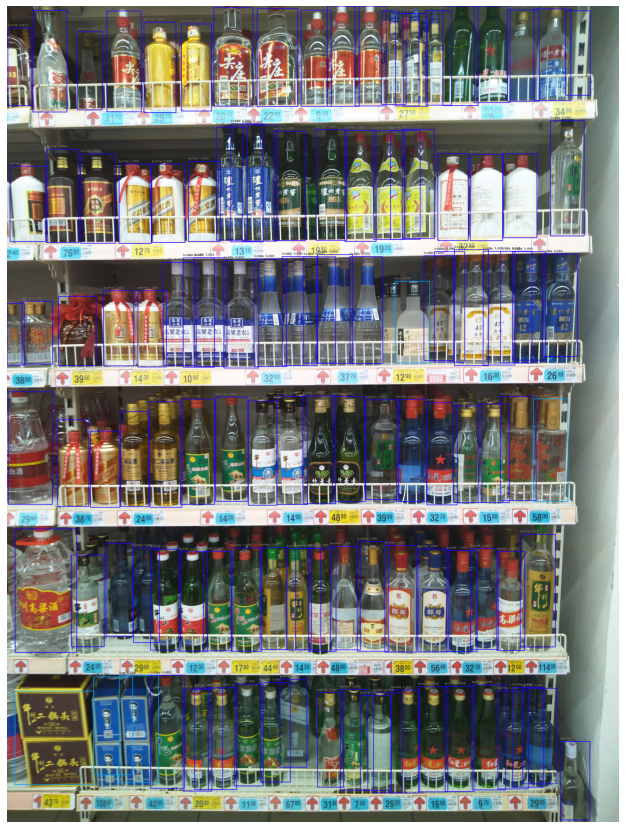

In [5]:
# load image
image = read_image_bgr('test_2.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()